In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import pip
pip.main(['install','seaborn'])
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.applications import DenseNet121, VGG19
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, LeakyReLU, GlobalAveragePooling2D, Conv2D, Input
from keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

modelclass = '5'
suffix = 'FIN'
iterations = 5
iterations2 = 5

def CreateModel(learn_rate):
    input_tensor = Input(shape=(256, 256, 3))
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    for layer in base_model.layers[:10]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(negative_slope=0.01)(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learn_rate),
                  loss=BinaryFocalCrossentropy(),
                  metrics=['accuracy'])

    return model

base_dir = '../../Data/Arrays/'
class_dir = 'Converted Arrays/'
train_images = np.load(os.path.join(base_dir, 'train_images.npy'))
train_labels = np.load(os.path.join(class_dir, f'train_labels_class{modelclass}.npy'))
val_images = np.load(os.path.join(base_dir, 'val_images.npy'))
val_labels = np.load(os.path.join(class_dir, f'val_labels_class{modelclass}.npy'))

if len(train_images.shape) == 3:
    train_images = np.expand_dims(train_images, axis=-1)
    train_images = np.repeat(train_images, 3, axis=-1)

if len(val_images.shape) == 3:
    val_images = np.expand_dims(val_images, axis=-1)
    val_images = np.repeat(val_images, 3, axis=-1)

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels.flatten())
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

print("Initial class weights:", class_weights)
print("Start time: ", datetime.datetime.now())

best_model_path = f'Models/class{suffix}{modelclass}temp.keras'
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

best_val_loss = float('inf')
for i in range(iterations):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-7)
    model = CreateModel(1e-5)
    print(f"Training iteration {i+1}/{iterations}")
    history = model.fit(train_images, train_labels,
                        epochs=50,
                        batch_size=16,
                        validation_data=(val_images, val_labels),
                        class_weight=class_weights,
                        callbacks=[early_stopping, reduce_lr, model_checkpoint])

    model.load_weights(best_model_path)
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Best current val:{best_val_loss}")
        model.save(f'Models/class_{suffix}{modelclass}_overallbest.keras')

print("Training Complete")

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: seaborn in /opt/conda/lib/python3.11/site-packages (0.13.2)

Requirement already satisfied: numpy!=1.24.0,>=1.20 in /opt/conda/lib/python3.11/site-packages (from seaborn) (1.26.4)

Requirement already satisfied: pandas>=1.2 in /opt/conda/lib/python3.11/site-packages (from seaborn) (2.2.3)

Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /opt/conda/lib/python3.11/site-packages (from seaborn) (3.9.3)

Requirement already satisfied: contourpy>=1.0.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.3.1)

Requirement already satisfied: cycler>=0.10 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.12.1)

Requirement already satisfied: fonttools>=4.22.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.55.3)

Requirement already satisfied: kiwisolver>=1.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.4.7)

Requirement already satisfied: packaging>=20.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (24.2)

Requirement already satisfied: pillow>=8 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (10.4.0)

Requirement already satisfied: pyparsing>=2.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (3.2.0)

Requirement already satisfied: python-dateutil>=2.7 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (2.9.0.post0)

Requirement already satisfied: pytz>=2020.1 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2023.3)

Requirement already satisfied: tzdata>=2022.7 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2024.2)

Requirement already satisfied: six>=1.5 in /opt/conda/lib/python3.11/site-packages (from python-dateutil>=2.7->matplotlib!=3.6.1,>=3.4->seaborn) (1.17.0)

Initial class weights: {0: 0.6233480176211453, 1: 2.5267857142857144}
Start time:  2025-01-16 10:56:57.714632


I0000 00:00:1737025017.872050    8081 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737025017.926115    8081 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737025017.929605    8081 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737025017.933782    8081 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Training iteration 1/5
Epoch 1/50


I0000 00:00:1737025028.643556    8125 service.cc:146] XLA service 0x7efd9c016f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737025028.643588    8125 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


  1/354 ━━━━━━━━━━━━━━━━━━━━ 1:57:23 20s/step - accuracy: 0.5000 - loss: 0.2193

I0000 00:00:1737025045.747524    8125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5066 - loss: 0.1894

E0000 00:00:1737025117.457964    8125 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737025117.678702    8125 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


354/354 ━━━━━━━━━━━━━━━━━━━━ 116s 272ms/step - accuracy: 0.5066 - loss: 0.1894 - val_accuracy: 0.1917 - val_loss: 0.1759 - learning_rate: 1.0000e-05
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 75s 212ms/step - accuracy: 0.4828 - loss: 0.1733 - val_accuracy: 0.6784 - val_loss: 0.1703 - learning_rate: 1.0000e-05
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 75s 212ms/step - accuracy: 0.5320 - loss: 0.1741 - val_accuracy: 0.8110 - val_loss: 0.1611 - learning_rate: 1.0000e-05
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.6392 - loss: 0.1670 - val_accuracy: 0.5150 - val_loss: 0.1839 - learning_rate: 1.0000e-05
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 75s 213ms/step - accuracy: 0.6406 - loss: 0.1650 - val_accuracy: 0.7049 - val_loss: 0.1604 - learning_rate: 1.0000e-05
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.6718 - loss: 0.1590 - val_accuracy: 0.6475 - val_loss: 0.1616 - learning_rate: 1.0000e-05
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step -

In [ ]:
best_model_path = f'Models/class{suffix}secondary{modelclass}temp.keras'
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')
best_val_loss = float('inf')
for i in range (iterations2):
    model = CreateModel(1e-7)
    model.load_weights(f'Models/class_{suffix}{modelclass}_overallbest.keras')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)
    
    print(f"Training iteration {i+1}/{iterations2}")
    history = model.fit(train_images, train_labels,
                        epochs=50,
                        batch_size=16,
                        validation_data=(val_images, val_labels),
                        class_weight=class_weights,
                        callbacks=[early_stopping, reduce_lr, model_checkpoint])

    model.load_weights(best_model_path)
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Best last val:{val_loss}")
        print(f"Best current val:{best_val_loss}")
        model.save(f'Models/class_{suffix}{modelclass}_overallbestFIN.keras')

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training iteration 1/5
Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 83s 223ms/step - accuracy: 0.7815 - loss: 0.1496 - val_accuracy: 0.7102 - val_loss: 0.1499 - learning_rate: 1.0000e-07
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.7193 - loss: 0.1486 - val_accuracy: 0.6873 - val_loss: 0.1542 - learning_rate: 1.0000e-07
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.7025 - loss: 0.1503 - val_accuracy: 0.6890 - val_loss: 0.1529 - learning_rate: 1.0000e-07
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.7106 - loss: 0.1451 - val_accuracy: 0.6961 - val_loss: 0.1502 - learning_rate: 1.0000e-07
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 210ms/step - accuracy: 0.7294 - loss: 0.1460 - val_accuracy: 0.6943 - val_loss: 0.1504 - learning_rate: 1.0000e-08
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 210ms/step - accuracy: 0.7253 - loss: 0.1476 - val_accuracy: 0.6952 - val_loss: 0.1508 - learning_rate: 1.0000e-08
Best last val:0.1499459

24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 569ms/step - accuracy: 0.6857 - loss: 0.1490
Test Loss: 0.1511780023574829
Test Accuracy: 0.6887417435646057
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step


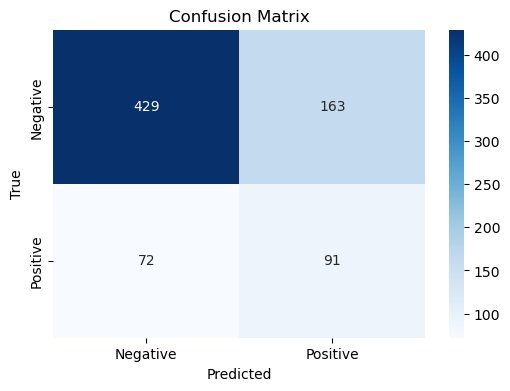

E0000 00:00:1737032069.306313    8123 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737032069.502922    8123 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


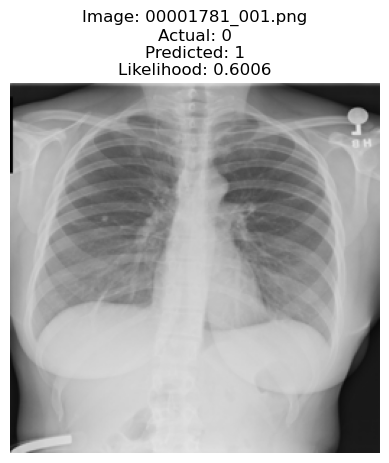

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


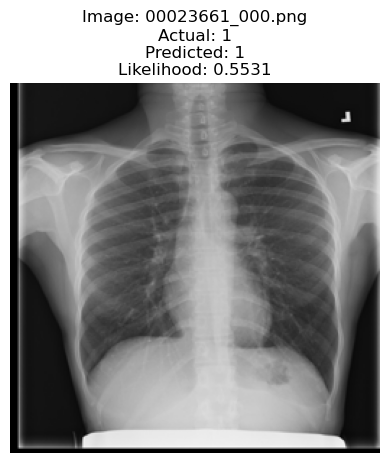

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


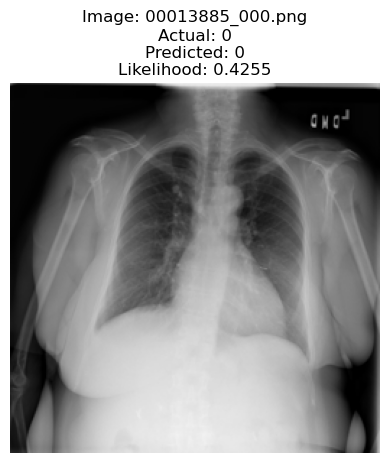

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


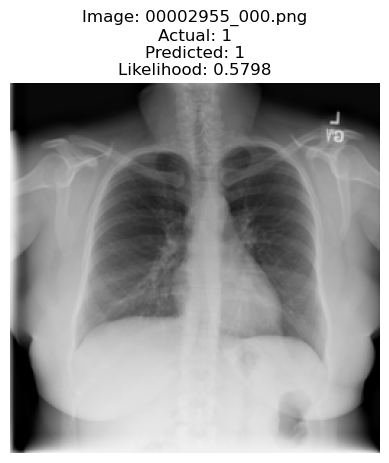

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


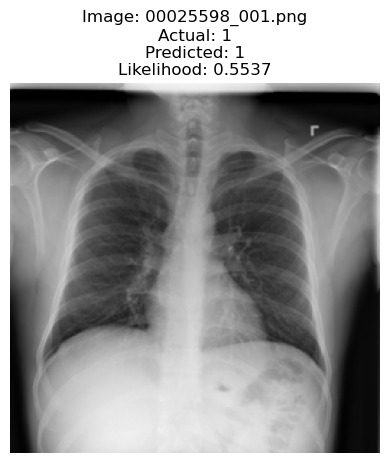

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


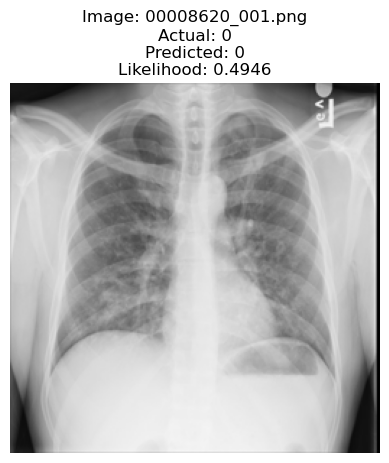

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


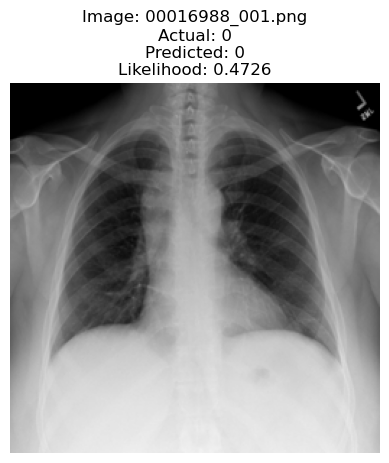

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


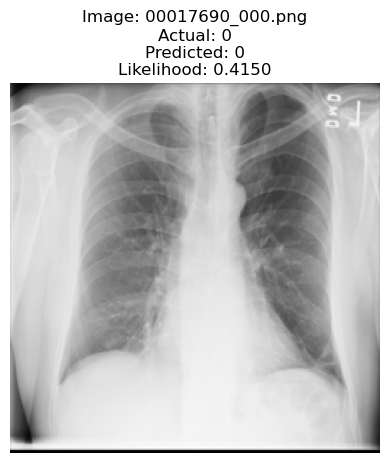

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


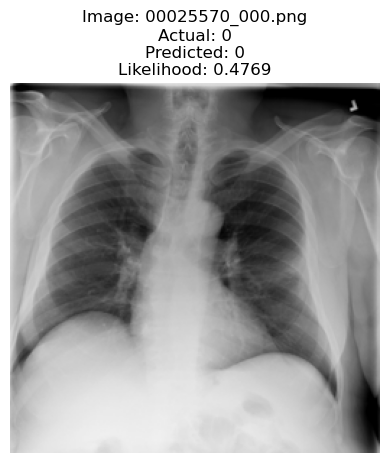

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


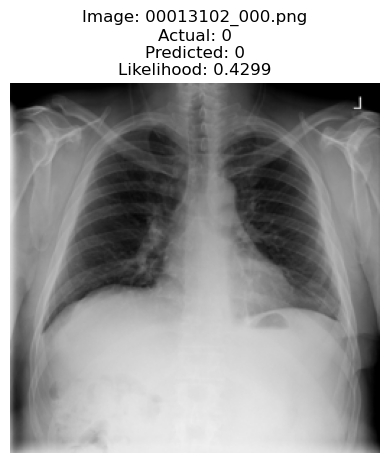

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


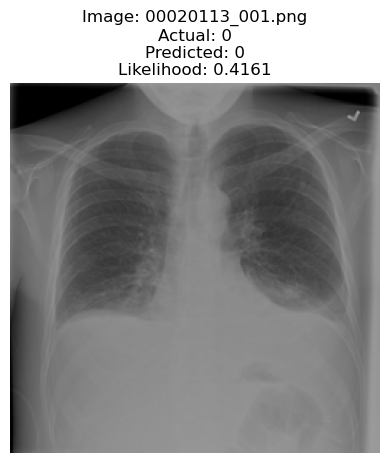

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


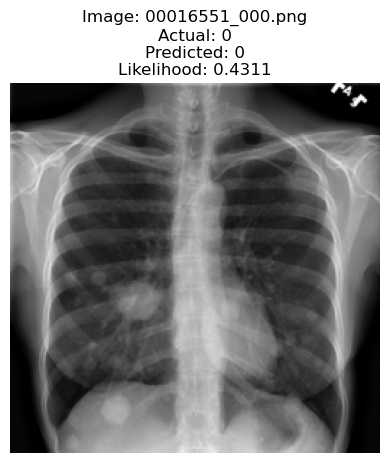

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


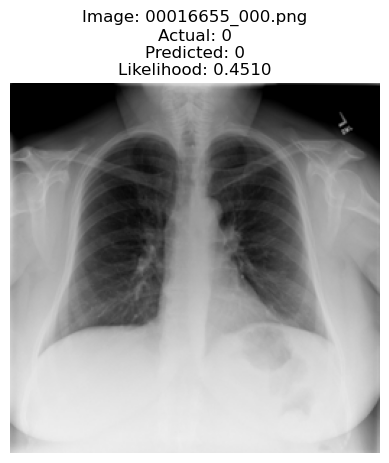

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


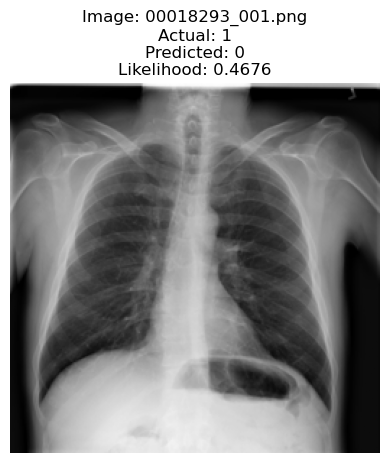

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


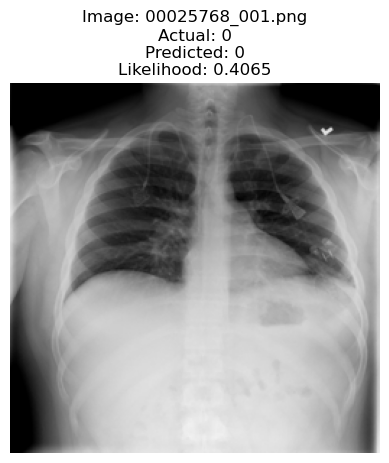

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


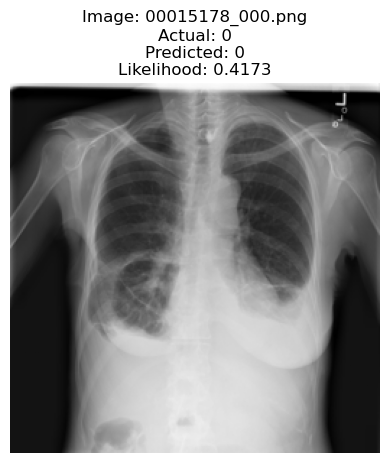

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


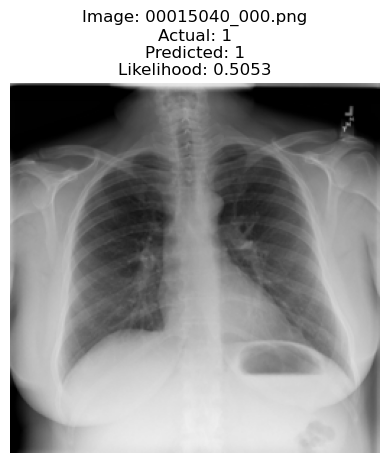

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


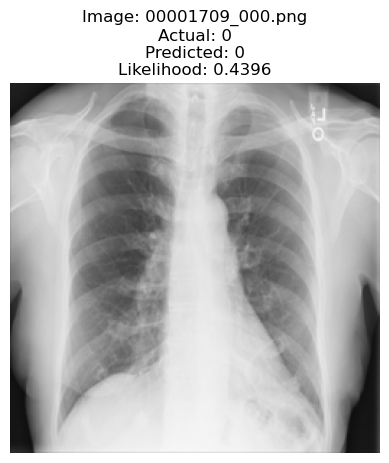

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


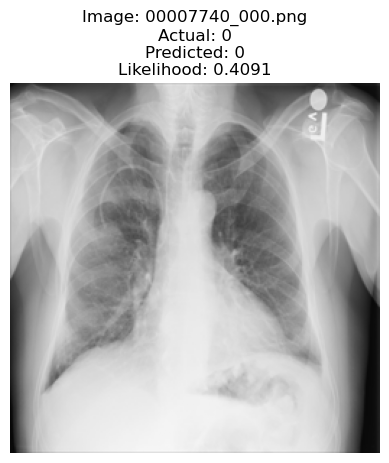

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


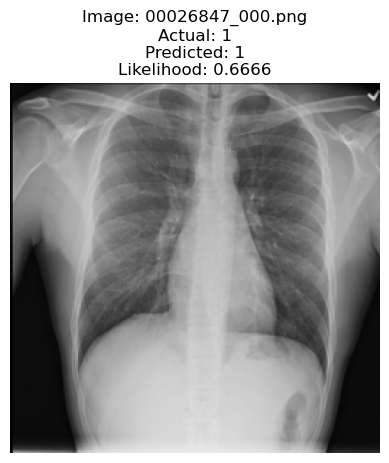

In [ ]:

test_images = np.load(os.path.join(base_dir, 'test_images.npy'))
test_labels = np.load(os.path.join(class_dir, f'test_labels_class{modelclass}.npy'))
test_image_names = np.load(os.path.join(base_dir, 'test_image_names.npy'), allow_pickle=True)

if len(test_images.shape) == 3:
    test_images = np.expand_dims(test_images, axis=-1)
    test_images = np.repeat(test_images, 3, axis=-1)

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.5).astype(int)

cm = confusion_matrix(test_labels, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

def display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Image: {image_name}\nActual: {actual_label}\nPredicted: {predicted_label}\nLikelihood: {likelihood:.4f}")
    plt.axis('off')
    plt.show()

num_samples = 20
indices = random.sample(range(test_images.shape[0]), num_samples)

for idx in indices:
    image = test_images[idx]
    image_name = test_image_names[idx]
    actual_label = test_labels[idx][0]
    image_expanded = np.expand_dims(image, axis=0)
    prediction = model.predict(image_expanded)[0][0]
    
    threshold = 0.5
    predicted_label = int(prediction > threshold)
    likelihood = prediction
    
    display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood)